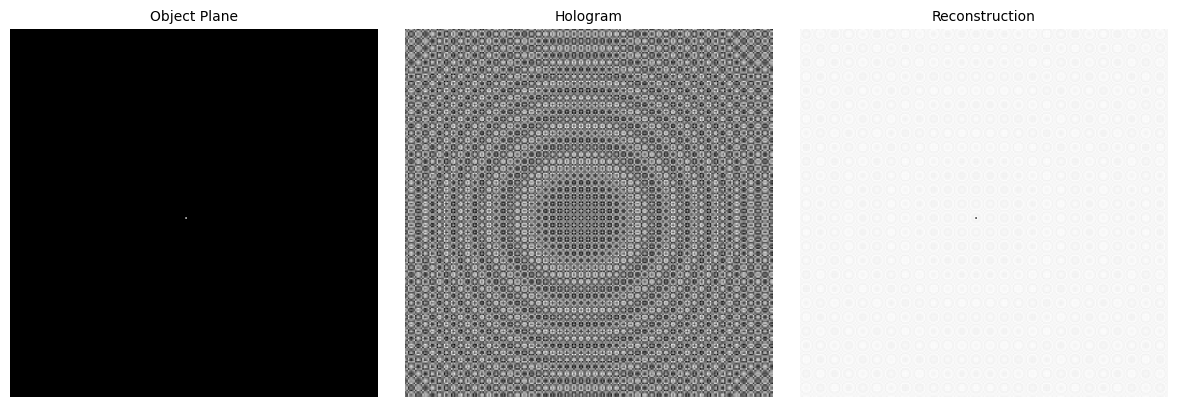

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Parameters
wavelength = 632.8e-9  # Red HeNe laser (m)
k = 2 * np.pi / wavelength
z = 0.2                # Propagation distance (m)
N = 256                # Grid size
dx = 10e-6             # Pixel pitch (m)
x = np.linspace(-N//2, N//2-1, N) * dx
X, Y = np.meshgrid(x, x)

# Fresnel propagation function
def fresnel_propagate(U0, z, wavelength, dx):
    N = U0.shape[0]
    fx = np.fft.fftfreq(N, d=dx)
    FX, FY = np.meshgrid(fx, fx)
    H = np.exp(1j * k * z) * np.exp(-1j * np.pi * wavelength * z * (FX**2 + FY**2))
    U1 = np.fft.ifft2(np.fft.fft2(U0) * H)
    return U1

# Initialize object motion path (sine wave)
def object_field(t):
    obj = np.zeros((N, N), dtype=complex)
    # Moving point object
    x_pos = int(N//2 + 40 * np.sin(2 * np.pi * t / 50))
    y_pos = int(N//2 + 40 * np.cos(2 * np.pi * t / 80))
    obj[y_pos, x_pos] = 1.0
    return obj

# Reference wave (plane wave)
ref_wave = np.ones((N, N), dtype=complex)

# Animation update function
def update(frame):
    obj = object_field(frame)

    # Simulate hologram (interference of object and reference waves)
    U_obj = fresnel_propagate(obj, z, wavelength, dx)
    hologram = np.abs(U_obj + ref_wave)**2

    # Reconstruction from hologram
    recon = fresnel_propagate(hologram, -z, wavelength, dx)

    # Update plots
    im_obj.set_array(np.abs(obj)**2)
    im_holo.set_array(hologram)
    im_recon.set_array(np.abs(recon)**2)
    return im_obj, im_holo, im_recon

# Set up figure with 3 panels
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
titles = ["Object Plane", "Hologram", "Reconstruction"]

# First frame initialization
obj0 = object_field(0)
U_obj0 = fresnel_propagate(obj0, z, wavelength, dx)
holo0 = np.abs(U_obj0 + ref_wave)**2
recon0 = fresnel_propagate(holo0, -z, wavelength, dx)

# Display panels
im_obj = axes[0].imshow(np.abs(obj0)**2, cmap='gray', vmin=0, vmax=1)
im_holo = axes[1].imshow(holo0, cmap='gray')
im_recon = axes[2].imshow(np.abs(recon0)**2, cmap='gray')

# Titles & cleanup
for ax, title in zip(axes, titles):
    ax.set_title(title, fontsize=10)
    ax.axis('off')

# Animation
ani = animation.FuncAnimation(fig, update, frames=100, interval=50, blit=True)
ani.save("wavefront_propagation.gif", writer="pillow", fps=20)

plt.tight_layout()
plt.show()
